# VQE

The Variational Quantum Eigensolver (VQE) is a central algorithm in many applications from e.g. quantum chemistry or optimization.
This tutorial shows you how to run the VQE as a Qiskit Runtime program. We'll start off by defining the algorithm settings, such as the Hamiltonian and ansatz, and then run a VQE both locally, on your machine, and remotely, using the Qiskit Runtime.

**Note:** You can find tutorials on solving more comprehensive problems, such as finding the ground state of the lithium hydride molecule, using the VQE (and Qiskit Runtime) within [the tutorials of Qiskit Nature](https://github.com/Qiskit/qiskit-nature/tree/main/docs/tutorials).

## System Hamiltonian

Let's start by defining the operator of which we want to determine the ground state. Here we'll chose a simple diagonal Hamiltonian $\hat H$ acting with Pauli-Z operators on the first two qubits

$$
\hat H = \hat Z_0 \otimes \hat Z_1.
$$

We can construct this Hamiltonian with Qiskit's `opflow` module:

In [1]:
from qiskit.opflow import Z, I

num_qubits = 4
hamiltonian = (Z ^ Z) ^ (I ^ (num_qubits - 2))

This Hamiltonian has a ground state energy of -1.

In [2]:
target_energy = -1

## Parameterized Ansatz Circuit

Next, we choose a parameterized quantum circuit $\hat U(\theta)$ to prepare the ansatz wavefunction

$$
|\psi(\theta)\rangle = \hat U(\theta)|0\rangle.
$$

We'll use the `EfficientSU2` circuit from Qiskit's circuit library, which is a hardware efficient, heuristic ansatz with alternating rotation and entanglement layers.

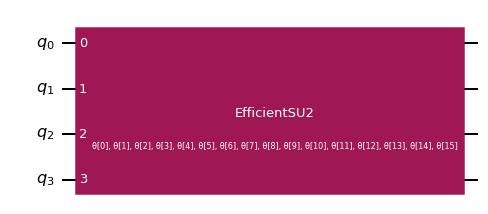

In [3]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement="linear", insert_barriers=True)
ansatz.draw("mpl", style="iqx")

## Solve with the VQE

Now that we have the problem and ansatz specified we can use the Variational Quantum Eigensolver (VQE) to solve for the minimal eigenvalue of our Hamiltonian.

The VQE requires a classical optimization routine, along with an initial point, to calculate the parameter updates.

In [4]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

To access intermediate information we can pass a callback into the VQE. The callback is given the current number of function evaluations, the current parameters, function values and standard deviation in the expectation evaluation. 

In [5]:
intermediate_info = {"nfev": [], "parameters": [], "energy": [], "stddev": []}


def callback(nfev, parameters, energy, stddev):
    intermediate_info["nfev"].append(nfev)
    intermediate_info["parameters"].append(parameters)
    intermediate_info["energy"].append(energy)
    intermediate_info["stddev"].append(stddev)

### Local VQE

Before running the Qiskit Runtime VQE program, let's first simulate this system locally using Qiskit's `VQE` class.

In [6]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    quantum_instance=QasmSimulatorPy(),
    callback=callback,
)

In [7]:
local_result = local_vqe.compute_minimum_eigenvalue(hamiltonian)

In [8]:
print("Eigenvalue:", local_result.eigenvalue)
print("Target:", target_energy)

Eigenvalue: (-0.990234375+0j)
Target: -1


With the information from the callback, we can for instance compute the average of the estimation errors in the expectation evaluations. For an exact (statevector) simulation this would be 0, but for a shot-based readout as we have on real hardware, this will be a small finite error.

In [9]:
print("Mean error:", np.mean(intermediate_info["stddev"]))

Mean error: 0.01785675968991925


### Qiskit Runtime VQE

To call the VQE code on the Qiskit Runtime on the cloud, we interact with the `run` method of `IBMRuntimeService`:
```
service.run(progam_id, inputs, options, callback)
```
where 
* `program_id` determines the Qiskit Runtime program run, i.e. `'vqe'` for the VQE
* `inputs` contains the input for the VQE algorithm
* `options` specifies the backend
* `callback` is the callback used inside the VQE

We start by initializing an account with access to the Qiskit Runtime service and the backend to execute the circuits on

In [10]:
from qiskit_ibm_runtime import IBMRuntimeService

service = IBMRuntimeService(auth="legacy")

We're using the `ibmq_montreal` device, but you can replace this with another device you have access to.

In [11]:
backend = service.backend("ibmq_montreal")

Let's gather all the inputs to the VQE in a dictionary.

In [12]:
vqe_inputs = {
    "ansatz": ansatz,
    "operator": hamiltonian,
    "optimizer": {"name": "SPSA", "maxiter": 5},  # let's only do a few iterations!
    "initial_point": initial_point,
    "measurement_error_mitigation": True,
    "shots": 1024,
}

The backend options only need to contain the name of the backend.

In [13]:
backend_options = {"backend_name": backend.name}

The callback acts a little different than before. Instead of only being passed the VQE callback arguments, it is passed a tuple with the job ID as first argument, followed by the VQE arguments.

In [14]:
intermediate_info = {"nfev": [], "parameters": [], "energy": [], "stddev": []}


def raw_callback(*args):
    job_id, (nfev, parameters, energy, stddev) = args
    intermediate_info["nfev"].append(nfev)
    intermediate_info["parameters"].append(parameters)
    intermediate_info["energy"].append(energy)
    intermediate_info["stddev"].append(stddev)

Now we can call the Qiskit Runtime VQE program.
Note, that the result will not be of the same type as `VQE`, but a plain dictionary.

In [15]:
job = service.run(
    program_id="vqe", inputs=vqe_inputs, options=backend_options, callback=raw_callback
)
print("Job ID:", job.job_id)

Job ID: c7fiugi0jbtu2e0fh0gg


In [16]:
result = job.result()

In [17]:
print(
    f'Reached {result["optimal_value"]} after {result["optimizer_evals"]} evaluations.'
)

Reached -0.5947265625 after None evaluations.


In [18]:
print("Available keys:", list(result.keys()))

Available keys: ['optimizer_evals', 'optimizer_time', 'optimal_value', 'optimal_point', 'optimal_parameters', 'cost_function_evals', 'eigenstate', 'eigenvalue', 'aux_operator_eigenvalues', 'optimizer_history']


In [19]:
from qiskit.tools.jupyter import *

%qiskit_copyright